In [1]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import folium
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

**In this notebook, I use data from the Bureau of Transportation Statistics, Wikipedia, Gas Buddy, Weather Underground, and Foursquare.**

**In the next several cells, I create a dataframe with columns for U.S airport codes, cities/states, latitudes, and longitudes.**

In [2]:
# CSV file from https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID='
df = pd.read_csv('/Users/asamarakone/Desktop/IBM Applied Data Science Capstone/292222040_T_MASTER_CORD.csv')

df.tail(7)

,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_COUNTRY_NAME,AIRPORT_STATE_NAME,LATITUDE,LONGITUDE,Unnamed: 7
17441,ZZU,Mzuzu Airport,"Mzuzu, Malawi",Malawi,NaN,-11.444167,34.012500,NaN
17442,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.892222,NaN
17443,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.942778,-81.892500,NaN
17444,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.891944,NaN
17445,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.892222,NaN
17446,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.891944,NaN
17447,ZZZ,Unknown Point in Alaska,Unknown Point in Alaska,United States,Alaska,NaN,NaN,NaN


In [3]:
# Truncate to only U.S airports
df = df[df.loc[:,'AIRPORT_COUNTRY_NAME'] == 'United States']
df.tail(7)

,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_COUNTRY_NAME,AIRPORT_STATE_NAME,LATITUDE,LONGITUDE,Unnamed: 7
17435,ZXZ,Waterville Airport,"Waterville, WA",United States,Washington,47.656111,-120.056389,NaN
17442,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.892222,NaN
17443,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.942778,-81.892500,NaN
17444,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.891944,NaN
17445,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.892222,NaN
17446,ZZV,Zanesville Municipal,"Zanesville, OH",United States,Ohio,39.944444,-81.891944,NaN
17447,ZZZ,Unknown Point in Alaska,Unknown Point in Alaska,United States,Alaska,NaN,NaN,NaN


In [4]:
# Check the last column
df.iloc[:,-1].unique()

array([nan])

In [5]:
# Group by airport name because the 5 different coordinates for ZZV suggest that there may be other airports with 
# more than 1 set of coordinates. Average the set(s) of coordinates for each airport.
df = df.groupby(['AIRPORT','DISPLAY_AIRPORT_CITY_NAME_FULL']).mean()
df.tail(6)

,,LATITUDE,LONGITUDE,Unnamed: 7
AIRPORT,DISPLAY_AIRPORT_CITY_NAME_FULL,,,
ZXW,"Paradise, CA",39.710139,-121.615833,NaN
ZXX,"Kennewick, WA",46.218472,-119.209722,NaN
ZXY,"Delta, CO",38.784861,-108.064444,NaN
ZXZ,"Waterville, WA",47.655139,-120.055278,NaN
ZZV,"Zanesville, OH",39.944111,-81.892167,NaN
ZZZ,Unknown Point in Alaska,NaN,NaN,NaN


In [6]:
# Reset the index 
df.reset_index(inplace = True)
df.head(1)

,AIRPORT,DISPLAY_AIRPORT_CITY_NAME_FULL,LATITUDE,LONGITUDE,Unnamed: 7
0,01A,"Afognak Lake, AK",58.109444,-152.906667,NaN


In [7]:
# Remove the last column because it seems to only contain NaN, rename the columns, and then remove all
# rows that have NaN entries (e.g. last row)

df.drop('Unnamed: 7', axis = 1, inplace = True)
df.columns = ['Airport Code','Destination', 'Latitude','Longitude']
df.dropna(inplace = True)

df.tail(6)

,Airport Code,Destination,Latitude,Longitude
2811,ZXV,"Nappanee, IN",41.446111,-85.935185
2812,ZXW,"Paradise, CA",39.710139,-121.615833
2813,ZXX,"Kennewick, WA",46.218472,-119.209722
2814,ZXY,"Delta, CO",38.784861,-108.064444
2815,ZXZ,"Waterville, WA",47.655139,-120.055278
2816,ZZV,"Zanesville, OH",39.944111,-81.892167


**In this cell, I truncate the dataframe so it consists only of large airport hubs.**

In [8]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States').text
soup = BeautifulSoup(source,'lxml')

# Fill list with large U.S airport hubs from first table of a Wikipedia article
largeHubs = []
for i in range(2,len(soup.find('table').find_all('td')),18):
    largeHubs.append(soup.find('table').find_all('td')[i].text[0:-1])

# Change index to make truncating easier
df.set_index(df['Airport Code'], inplace = True)

# Truncate
df = df.loc[largeHubs]

# Sort alphabetically by airport code
df.sort_values('Airport Code', inplace = True)

# Drop any rows with NaN
df.dropna(inplace = True)

# Reset index
df.reset_index(drop = True,inplace = True)

print(df['Destination'].value_counts())
df.head(30)

Washington, DC           2
New York, NY             2
Chicago, IL              2
Baltimore, MD            1
Newark, NJ               1
Salt Lake City, UT       1
Tampa, FL                1
Las Vegas, NV            1
Charlotte, NC            1
Portland, OR             1
Boston, MA               1
Miami, FL                1
Houston, TX              1
Honolulu, HI             1
Minneapolis, MN          1
Fort Lauderdale, FL      1
San Diego, CA            1
Denver, CO               1
Orlando, FL              1
Atlanta, GA              1
Detroit, MI              1
Dallas/Fort Worth, TX    1
San Francisco, CA        1
Seattle, WA              1
Phoenix, AZ              1
Philadelphia, PA         1
Los Angeles, CA          1
Name: Destination, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'Airport Code' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()


,Airport Code,Destination,Latitude,Longitude
0,ATL,"Atlanta, GA",33.638452,-84.427619
1,BOS,"Boston, MA",42.363333,-71.006250
2,BWI,"Baltimore, MD",39.175444,-76.668889
3,CLT,"Charlotte, NC",35.215556,-80.942685
4,DCA,"Washington, DC",38.851667,-77.037611
5,DEN,"Denver, CO",39.818056,-104.776389
6,DFW,"Dallas/Fort Worth, TX",32.896528,-97.037083
7,DTW,"Detroit, MI",42.214583,-83.348889
8,EWR,"Newark, NJ",40.694167,-74.170139
9,FLL,"Fort Lauderdale, FL",26.072454,-80.151620


In [9]:
# Truncate dataframe so dataframe consists of only unique destinations and airports not too close to each other
df.drop([8,11,16,18], inplace = True)

**In this cell, I add 4 columns for estimated prices of regular, midgrade, premium, and diesel gas. **

In [10]:
#List of fuel type options
fuelTypes = list(range(1,5))   # Regular gas = 1, Midgrade = 2, Premium = 3, Diesel = 4

for fuelType in fuelTypes:
    # List to hold estimates of the gas price
    GasPriceEstimates = []
    for destination in df['Destination']:
        query = '{}, United States'.format(destination)
        source = requests.get('https://www.gasbuddy.com/home?search={}&fuel={}'.format(query,fuelType)).text
        soup = BeautifulSoup(source,'lxml')
        elements = soup.find_all('div', class_ = 'styles__priceContainer___1QH4L')
        # List to hold <= 10 gas prices from resulting webpage
        prices = []
        # Fill list
        for i in range(len(elements)):
            price = elements[i].find('span').text
            if price != '---':     
                price = float(price.split('$')[1])
                prices.append(price)
        # Add the mean of the prices to GasPriceEstimates
        GasPriceEstimates.append(np.mean(prices)) 
    # Add column
    if fuelType == 1:
        df['Regular Gas Price Estimate [$]'] = GasPriceEstimates
    elif fuelType == 2:
        df['Midgrade Gas Price Estimate [$]'] = GasPriceEstimates
    elif fuelType == 3:
        df['Premium Gas Price Estimate [$]'] = GasPriceEstimates
    else:
        df['Diesel Gas Price Estimate [$]'] = GasPriceEstimates
    print('{} column(s) completed'.format(fuelType))
        
#Drop any rows with NaN
df.dropna(inplace = True)

df.head()

1 column(s) completed
2 column(s) completed
3 column(s) completed
4 column(s) completed


,Airport Code,Destination,Latitude,Longitude,Regular Gas Price Estimate [$],Midgrade Gas Price Estimate [$],Premium Gas Price Estimate [$],Diesel Gas Price Estimate [$]
0,ATL,"Atlanta, GA",33.638452,-84.427619,2.946667,3.327143,3.683333,3.208750
1,BOS,"Boston, MA",42.363333,-71.006250,3.078571,3.413333,3.540000,3.600000
2,BWI,"Baltimore, MD",39.175444,-76.668889,2.830000,3.133333,3.403333,3.250000
3,CLT,"Charlotte, NC",35.215556,-80.942685,2.708571,3.052500,3.390000,3.204286
4,DCA,"Washington, DC",38.851667,-77.037611,2.972500,3.466000,3.606000,3.174000


       Regular Gas Price Estimate [$]  Midgrade Gas Price Estimate [$]  \
count                       26.000000                        26.000000   
mean                         3.169135                         3.408512   
std                          0.455359                         0.400248   
min                          2.655714                         2.916667   
25%                          2.833571                         3.115833   
50%                          3.034786                         3.286875   
75%                          3.468500                         3.700562   
max                          4.032857                         4.175000   

       Premium Gas Price Estimate [$]  Diesel Gas Price Estimate [$]  
count                       26.000000                      26.000000  
mean                         3.634353                       3.473265  
std                          0.369644                       0.369642  
min                          3.190000            

{'whiskers': [<matplotlib.lines.Line2D at 0x1a140a9eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a140a9550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a140a9e48>,
 'medians': [<matplotlib.lines.Line2D at 0x1a14093358>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a14093780>,
 'means': []}

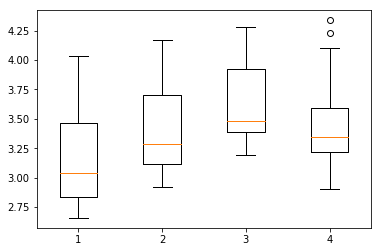

In [11]:
# Boxplot
print(df.iloc[:,4:].describe())
plt.boxplot([df['Regular Gas Price Estimate [$]'],df['Midgrade Gas Price Estimate [$]'],\
df['Premium Gas Price Estimate [$]'],df['Diesel Gas Price Estimate [$]']])

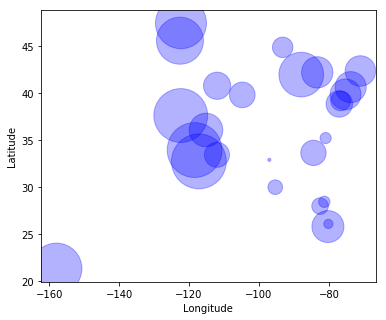

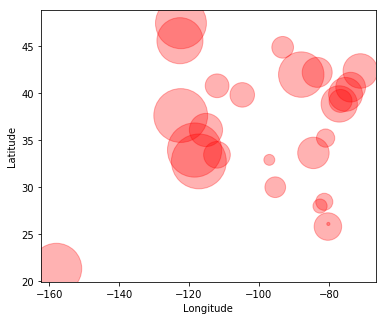

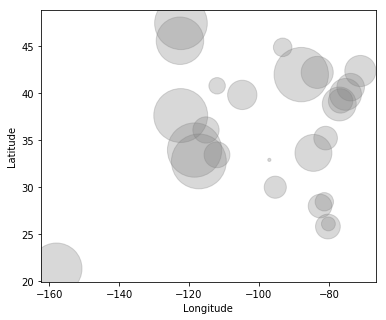

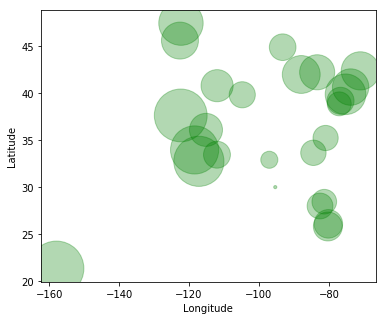

In [12]:
# Bubbleplot
norm_rgp = (df['Regular Gas Price Estimate [$]'] - df['Regular Gas Price Estimate [$]'].min()) / (df['Regular Gas Price Estimate [$]'].max() - df['Regular Gas Price Estimate [$]'].min())
norm_mgp = (df['Midgrade Gas Price Estimate [$]'] - df['Midgrade Gas Price Estimate [$]'].min()) / (df['Midgrade Gas Price Estimate [$]'].max() - df['Midgrade Gas Price Estimate [$]'].min())
norm_pgp = (df['Premium Gas Price Estimate [$]'] - df['Premium Gas Price Estimate [$]'].min()) / (df['Premium Gas Price Estimate [$]'].max() - df['Premium Gas Price Estimate [$]'].min())
norm_dgp = (df['Diesel Gas Price Estimate [$]'] - df['Diesel Gas Price Estimate [$]'].min()) / (df['Diesel Gas Price Estimate [$]'].max() - df['Diesel Gas Price Estimate [$]'].min())
ax = df.plot(kind='scatter',
                    x='Longitude',
                    y='Latitude',
                    figsize=(6, 5),
                    alpha=0.3,                  
                    color='Blue',
                    s = norm_rgp * 3000 + 10
                    )
ax = df.plot(kind='scatter',
                    x='Longitude',
                    y='Latitude',
                    figsize=(6, 5),
                    alpha=0.3,                  
                    color='Red',
                    s = norm_mgp * 3000 + 10
                    )
ax = df.plot(kind='scatter',
                    x='Longitude',
                    y='Latitude',
                    figsize=(6, 5),
                    alpha=0.3,                  
                    color='Grey',
                    s = norm_pgp * 3000 + 10
                    )
ax = df.plot(kind='scatter',
                    x='Longitude',
                    y='Latitude',
                    figsize=(6, 5),
                    alpha=0.3,                  
                    color='Green',
                    s = norm_dgp * 3000 + 10
                    )

**In this cell, I create 2 columns for estimates of yesterday's max temperature and yesterday's min temperature.**

In [13]:
yesterdaymaxtemps = []
yesterdaymintemps = []

for destination in df['Destination']:
    # State abbreviation
    stateAbv = destination.split(',')[1].lower()[1:]
    # City
    city = destination.split(',')[0].split('/')[0].lower().replace(' ','-')
    source = requests.get('https://www.wunderground.com/weather/us/{}/{}'.format(stateAbv,city)).text
    soup = BeautifulSoup(source,'lxml').find_all('script')
    # Try to find yesterday's max temperature 
    try:
        yesterdaymaxtemps.append(float(soup[5].text.split('yesterday_max_temperature":')[1].split(',')[0]))
    except:
        yesterdaymaxtemps.append(np.nan)   
    # Try to find yesterday's min temperature 
    try:
        yesterdaymintemps.append(float(soup[5].text.split('yesterday_min_temperature":')[1].split(',')[0]))
    except:
        yesterdaymintemps.append(np.nan)
        
# Add columns
df['Yesterday Max Temperature Estimate [F]'] = yesterdaymaxtemps
df['Yesterday Min Temperature Estimate [F]'] = yesterdaymintemps

# Drop rows with NaN
df.dropna(inplace = True)

In [14]:
df.sort_values('Airport Code',inplace = True)
df.reset_index(inplace = True, drop = True)
df.head(21)

,Airport Code,Destination,Latitude,Longitude,Regular Gas Price Estimate [$],Midgrade Gas Price Estimate [$],Premium Gas Price Estimate [$],Diesel Gas Price Estimate [$],Yesterday Max Temperature Estimate [F],Yesterday Min Temperature Estimate [F]
0,ATL,"Atlanta, GA",33.638452,-84.427619,2.946667,3.327143,3.683333,3.208750,65.2,42.1
1,BOS,"Boston, MA",42.363333,-71.006250,3.078571,3.413333,3.540000,3.600000,51.4,44.4
2,BWI,"Baltimore, MD",39.175444,-76.668889,2.830000,3.133333,3.403333,3.250000,55.2,41.9
3,CLT,"Charlotte, NC",35.215556,-80.942685,2.708571,3.052500,3.390000,3.204286,68.2,47.8
4,DEN,"Denver, CO",39.818056,-104.776389,2.954000,3.165000,3.500000,3.227143,79.2,45.5
5,DTW,"Detroit, MI",42.214583,-83.348889,3.102000,3.290000,3.562000,3.490000,43.6,36.1
6,FLL,"Fort Lauderdale, FL",26.072454,-80.151620,2.690000,2.916667,3.256667,3.290000,88.2,75.7
7,HNL,"Honolulu, HI",21.318111,-157.921167,3.843000,3.986000,4.139000,4.340000,87.3,77.2
8,IAH,"Houston, TX",29.983704,-95.340463,2.750000,3.092000,3.365000,2.905000,74.7,59.3
9,JFK,"New York, NY",40.639611,-73.778389,3.095714,3.283750,3.464286,3.535714,54.2,51.5


       Yesterday Max Temperature Estimate [F]  \
count                               22.000000   
mean                                69.254545   
std                                 13.810649   
min                                 43.600000   
25%                                 56.275000   
50%                                 70.400000   
75%                                 81.050000   
max                                 88.200000   

       Yesterday Min Temperature Estimate [F]  
count                               22.000000  
mean                                52.831818  
std                                 14.967374  
min                                 25.400000  
25%                                 44.550000  
50%                                 49.650000  
75%                                 65.150000  
max                                 77.200000  


{'whiskers': [<matplotlib.lines.Line2D at 0x1a14011a20>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1400c320>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a140118d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1a1400cb70>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a1400cf98>,
 'means': []}

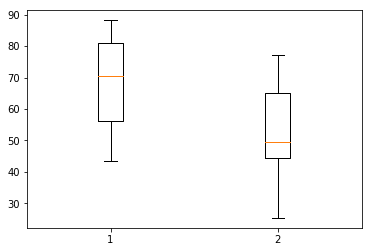

In [15]:
# Box plot 
print(df.iloc[:,-2:].describe())
plt.boxplot([df['Yesterday Max Temperature Estimate [F]'],\
df['Yesterday Min Temperature Estimate [F]']])

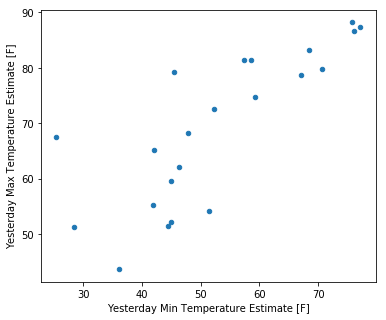

In [16]:
# Scatter plot
ax = df.plot(kind='scatter',
                    x='Yesterday Min Temperature Estimate [F]',
                    y='Yesterday Max Temperature Estimate [F]',
                    figsize=(6, 5))

**In the next several cells, I repeat some of the ungraded lab work done with Foursquare.**

In [17]:
# Foursquare credentials
CLIENT_ID = 'Z3DIG2FE2ODBVM4WHAHRBVAYMPFMQFE4FZERKYKPXRQBIVCL' 
CLIENT_SECRET = 'TRLMJL4F13DZSBEJBFSLDFSMXZJHS454BWV4EU03WBT00XIY' 
VERSION = '20180605' 

In [18]:
# Function from ungraded lab with some minor changes
def getNearbyVenues(names, latitudes, longitudes, radius= 16000):
    
    LIMIT = 1000
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Airport', 
                  'Airport Latitude', 
                  'Airport Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
Venues = getNearbyVenues(df['Airport Code'],df['Latitude'],df['Longitude'])
Venues.sort_values('Airport',inplace=True)

In [20]:
Venues.reset_index(drop = True, inplace=True)

In [21]:
# One hot encoding
onehot = pd.get_dummies(Venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
onehot['Airport'] = Venues['Airport'] 

onehot = onehot[['Airport'] + list(onehot.columns[onehot.columns != 'Airport'])]
onehot.head(10)

,Airport,Accessories Store,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,ATL,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ATL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
grouped = onehot.groupby('Airport').mean().reset_index()
grouped.sort_values('Airport',inplace = True)
grouped.head(21)

,Airport,Accessories Store,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,ATL,0.00,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.02
1,BOS,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00
2,BWI,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00
3,CLT,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.01,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
4,DEN,0.01,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00
5,DTW,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
6,FLL,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
7,HNL,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00
8,IAH,0.00,0.01,0.05,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,JFK,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00


In [26]:
# Add columns back
grouped['Yesterday Max Temperature Estimate [F]'] = df['Yesterday Max Temperature Estimate [F]']
grouped['Yesterday Min Temperature Estimate [F]'] = df['Yesterday Min Temperature Estimate [F]']
grouped['Regular Gas Price Estimate [$]'] = df['Regular Gas Price Estimate [$]']
grouped['Midgrade Gas Price Estimate [$]'] = df['Midgrade Gas Price Estimate [$]']
grouped['Premium Gas Price Estimate [$]'] = df['Premium Gas Price Estimate [$]']
grouped['Diesel Gas Price Estimate [$]'] = df['Diesel Gas Price Estimate [$]']
grouped['Destination'] = df['Destination']
grouped['Airport Latitude'] = df['Latitude']
grouped['Airport Longitude'] = df['Longitude']
# Drop some columns and rows
grouped.drop(['Airport Lounge'], axis = 1, inplace = True)
grouped.dropna(inplace = True)
# Order columns
grouped = grouped[list(grouped.columns[0:1]) + list(grouped.columns[-3:]) + list(grouped.columns[-9:-3]) + list(grouped.columns[0:-9])]
grouped.head(21)

,Airport,Destination,Airport Latitude,Airport Longitude,Yesterday Max Temperature Estimate [F],Yesterday Min Temperature Estimate [F],Regular Gas Price Estimate [$],Midgrade Gas Price Estimate [$],Premium Gas Price Estimate [$],Diesel Gas Price Estimate [$],...,Vietnamese Restaurant,Warehouse Store,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,ATL,"Atlanta, GA",33.638452,-84.427619,65.2,42.1,2.946667,3.327143,3.683333,3.208750,...,0.01,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.02
1,BOS,"Boston, MA",42.363333,-71.006250,51.4,44.4,3.078571,3.413333,3.540000,3.600000,...,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00
2,BWI,"Baltimore, MD",39.175444,-76.668889,55.2,41.9,2.830000,3.133333,3.403333,3.250000,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00
3,CLT,"Charlotte, NC",35.215556,-80.942685,68.2,47.8,2.708571,3.052500,3.390000,3.204286,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
4,DEN,"Denver, CO",39.818056,-104.776389,79.2,45.5,2.954000,3.165000,3.500000,3.227143,...,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00
5,DTW,"Detroit, MI",42.214583,-83.348889,43.6,36.1,3.102000,3.290000,3.562000,3.490000,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
6,FLL,"Fort Lauderdale, FL",26.072454,-80.151620,88.2,75.7,2.690000,2.916667,3.256667,3.290000,...,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
7,HNL,"Honolulu, HI",21.318111,-157.921167,87.3,77.2,3.843000,3.986000,4.139000,4.340000,...,0.02,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00
8,IAH,"Houston, TX",29.983704,-95.340463,74.7,59.3,2.750000,3.092000,3.365000,2.905000,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,JFK,"New York, NY",40.639611,-73.778389,54.2,51.5,3.095714,3.283750,3.464286,3.535714,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00


**For the rest of the notebook, I cluster the locations via 2 methods (DBSCAN and KMeans) 3 times (each time using a different set of columns (venue columns, gas price columns, or the temperature columns)**

In [27]:
# Make 3 different dataframes to be used in clustering

df_venues = grouped.drop(['Destination','Airport Latitude','Airport Longitude', 'Airport',\
'Yesterday Max Temperature Estimate [F]','Regular Gas Price Estimate [$]',\
'Yesterday Min Temperature Estimate [F]','Midgrade Gas Price Estimate [$]',
'Premium Gas Price Estimate [$]','Diesel Gas Price Estimate [$]'],1)
                         
df_gasprice = pd.DataFrame([grouped['Regular Gas Price Estimate [$]'],\
grouped['Midgrade Gas Price Estimate [$]'],grouped['Premium Gas Price Estimate [$]'],\
grouped['Diesel Gas Price Estimate [$]']]).T

df_temp = pd.DataFrame([grouped['Yesterday Max Temperature Estimate [F]'],\
grouped['Yesterday Min Temperature Estimate [F]']]).T

** In the next few cells, I cluster by using the venue columns. **

In [42]:
# Set number of clusters
kclusters = 6

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(df_venues)

# DBSCAN
db_clustering = StandardScaler().fit_transform(df_venues)
db = DBSCAN(eps=21, min_samples=4).fit(db_clustering)
db.labels_

array([ 0, -1,  0,  0, -1,  0,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0,
        0,  0, -1,  0,  0])

In [43]:
# Add column for KMeans labels (considering only venue data)
grouped['KMeans Labels (considering only venue data)'] = kmeans.labels_

# Add column for DBSCAN labels (considering only venue data)
grouped['DBSCAN Labels (considering only venue data)'] = db.labels_

** Visualization of KMeans labels (considering only venue data) **

In [44]:
# Create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=4)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped['Airport Latitude'], grouped['Airport Longitude'], grouped['Destination'], grouped['KMeans Labels (considering only venue data)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

** Visualization of DBSCAN labels (considering only venue data) **

In [45]:
# Create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=4)

# Set color scheme for the clusters
colors_array = cm.rainbow([0,0.5])
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped['Airport Latitude'], grouped['Airport Longitude'], grouped['Destination'], grouped['DBSCAN Labels (considering only venue data)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**In the next few cells, I cluster by using the gas price column.**

In [48]:
# Set number of clusters
kclusters = 4

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(df_gasprice)

# DBSCAN
db_clustering = StandardScaler().fit_transform(df_gasprice)
db = DBSCAN(eps=0.29, min_samples=2).fit(db_clustering)
db.labels_

array([-1,  0,  1,  2,  3, -1, -1, -1, -1, -1, -1,  2, -1,  1, -1, -1,  0,
        3, -1, -1, -1,  2])

In [49]:
# Add column for KMeans labels (considering only gas price data)
grouped['KMeans Labels (considering only gas prices data)'] = kmeans.labels_

# Add column for DBSCAN labels (considering only gas price data)
grouped['DBSCAN Labels (considering only gas prices data)'] = db.labels_

**Visualization of KMeans labels (considering only gas price data)**

In [50]:
# Create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=4)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped['Airport Latitude'], grouped['Airport Longitude'], grouped['Destination'], grouped['KMeans Labels (considering only gas prices data)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Visualization of DBSCAN labels (considering only gas price data)**

In [51]:
# Create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=4)

# Set color scheme for the clusters
x = np.arange(len(db.labels_))
ys = [i+x+(i*x)**2 for i in range(len(db.labels_))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped['Airport Latitude'], grouped['Airport Longitude'], grouped['Destination'], grouped['DBSCAN Labels (considering only gas prices data)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**In the next few cells, I cluster by using the temperature column.**

In [52]:
# Set number of clusters
kclusters = 4

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(df_temp)

# DBSCAN
db_clustering = StandardScaler().fit_transform(df_temp)
db = DBSCAN(eps=0.3, min_samples=2).fit(db_clustering)
db.labels_

array([-1,  0, -1, -1, -1, -1,  1,  1, -1, -1,  2,  3,  1, -1, -1,  4,  0,
        3,  2,  4, -1, -1])

In [53]:
# Add column for KMeans labels (considering only temperature data)
grouped['KMeans Labels (considering only temperature data)'] = kmeans.labels_

# Add column for DBSCAN labels (considering only temperature data)
grouped['DBSCAN Labels (considering only temperature data)'] = db.labels_

**Visualization of KMeans labels (considering only temperature data)**

In [54]:
# Create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=3)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped['Airport Latitude'], grouped['Airport Longitude'], grouped['Destination'], grouped['KMeans Labels (considering only temperature data)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Visualization of DBSCAN labels (considering only temperature data)**

In [55]:
# Create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()-22], zoom_start=3)

# Set color scheme for the clusters
x = np.arange(len(db.labels_))
ys = [i+x+(i*x)**2 for i in range(len(db.labels_))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grouped['Airport Latitude'], grouped['Airport Longitude'], grouped['Destination'], grouped['DBSCAN Labels (considering only temperature data)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [56]:
# Summary of labels
summary = grouped[['Destination','Airport','KMeans Labels (considering only temperature data)','DBSCAN Labels (considering only temperature data)',\
'KMeans Labels (considering only gas prices data)','DBSCAN Labels (considering only gas prices data)',\
'KMeans Labels (considering only venue data)','DBSCAN Labels (considering only venue data)']]

In [58]:
summary

,Destination,Airport,Airport,KMeans Labels (considering only temperature data),DBSCAN Labels (considering only temperature data),KMeans Labels (considering only gas prices data),DBSCAN Labels (considering only gas prices data),KMeans Labels (considering only venue data),DBSCAN Labels (considering only venue data)
0,"Atlanta, GA",ATL,ATL,2,-1,0,-1,2,0
1,"Boston, MA",BOS,BOS,2,0,0,0,2,-1
2,"Baltimore, MD",BWI,BWI,2,-1,2,1,2,0
3,"Charlotte, NC",CLT,CLT,3,-1,2,2,0,0
4,"Denver, CO",DEN,DEN,3,-1,2,3,0,-1
5,"Detroit, MI",DTW,DTW,0,-1,0,-1,1,0
6,"Fort Lauderdale, FL",FLL,FLL,1,1,2,-1,5,0
7,"Honolulu, HI",HNL,HNL,1,1,1,-1,4,-1
8,"Houston, TX",IAH,IAH,3,-1,2,-1,2,0
9,"New York, NY",JFK,JFK,2,-1,0,-1,3,-1
